In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import matplotlib.colors as mcolors
from skimage.transform import resize
import skimage.measure
import torch
from kornia.geometry.transform.imgwarp import warp_perspective, homography_warp
from skimage.transform import downscale_local_mean
import sys
sys.path.append('/home/lakabuli/workspace/LenslessInfoDesign/EncodingInformation/lensless_imager')
from lensless_helpers import *

In [ ]:
save_dir = '/home/lakabuli/workspace/LenslessInfoDesign/figures/'

In [ ]:
inferno = plt.cm.get_cmap('inferno', 11)
colors = [inferno(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]]

/tmp/ipykernel_1878350/3677707093.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno = plt.cm.get_cmap('inferno', 11) # max photon count value, using each tick point smoothly gives a better color gradient that isn't uniform


In [4]:
def mtf_of_psf(psf, normalize=True):
    psf_fft = fft.fft2(psf)
    psf_fft = fft.fftshift(psf_fft)
    mtf = np.abs(psf_fft)
    if normalize:
        mtf = mtf / mtf.max()
    return mtf

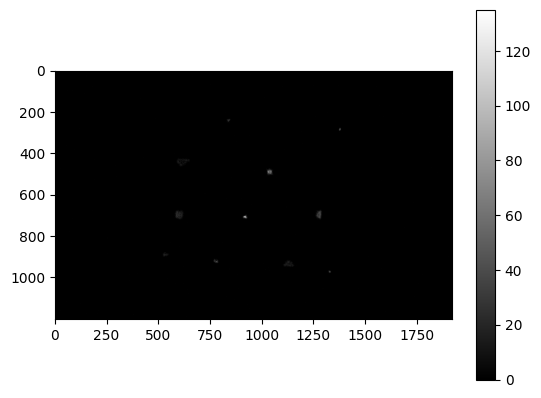

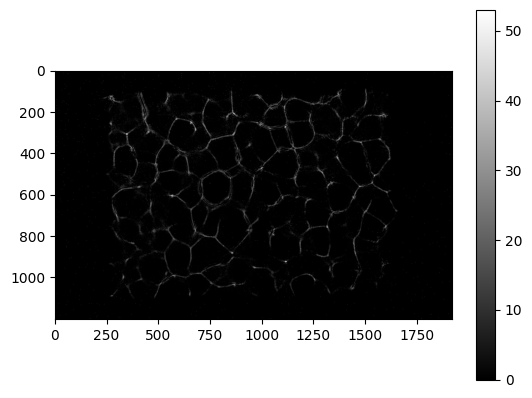

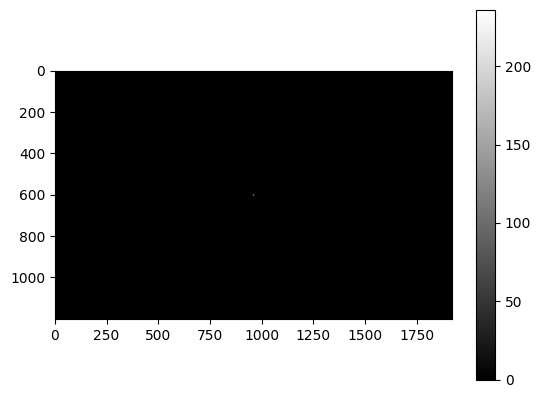

In [ ]:
psf_dir = '/home/lakabuli/cosmos_drive/psfs/mono8_psfs/'
rml_psf = psf_dir + 'psf_3000.0_img_2_cam_1_rml.tiff'
rml_psf = plt.imread(rml_psf)
plt.imshow(rml_psf, cmap='gray')
plt.colorbar()

plt.figure()

diffuser_psf = psf_dir + 'psf_5000.0_img_2_cam_0_diffusercam.tiff'
diffuser_psf = plt.imread(diffuser_psf)
plt.imshow(diffuser_psf, cmap='gray')
plt.colorbar()

gt_psf = psf_dir + 'psf_5000_cam_0_ground_truth.tiff'
gt_psf = plt.imread(gt_psf)
plt.figure()
plt.imshow(gt_psf, cmap='gray')
plt.colorbar()

In [7]:
axis_label_fontsize = 21
title_fontsize = 23
tick_fontsize = 19
legend_fontsize = 16

### MTF calculation: Fig. 4b and Fig. S6

Uses MTF binning to smooth single MTF cross sections for better visualization

1.0 1.0 1.0
1.0 1.0 1.0
1.0
1.0 1.0 1.0
1.0


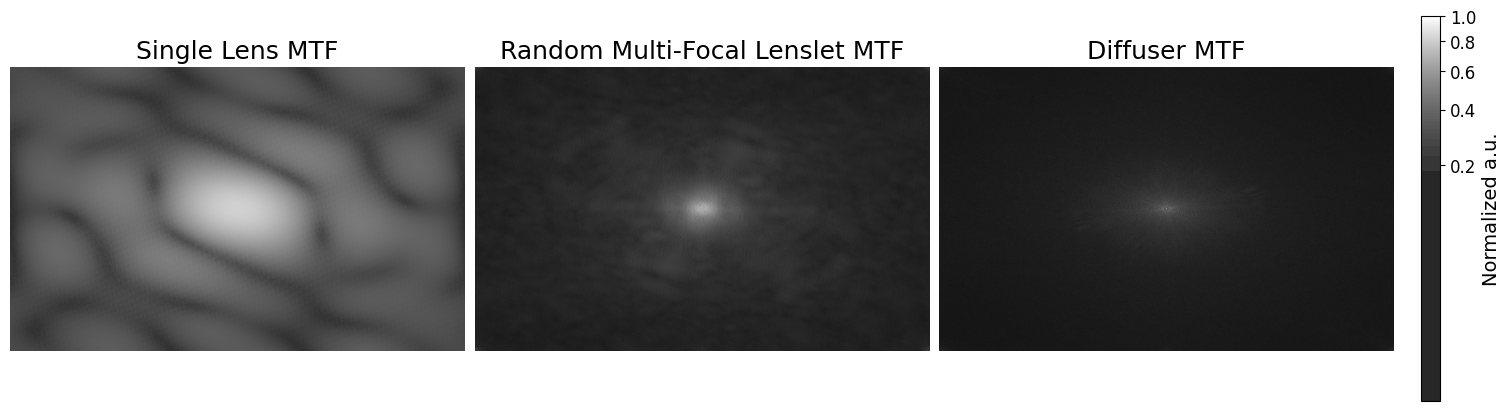

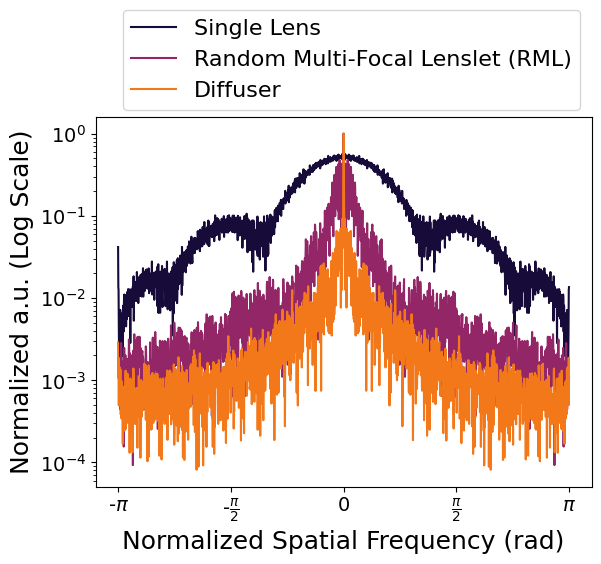

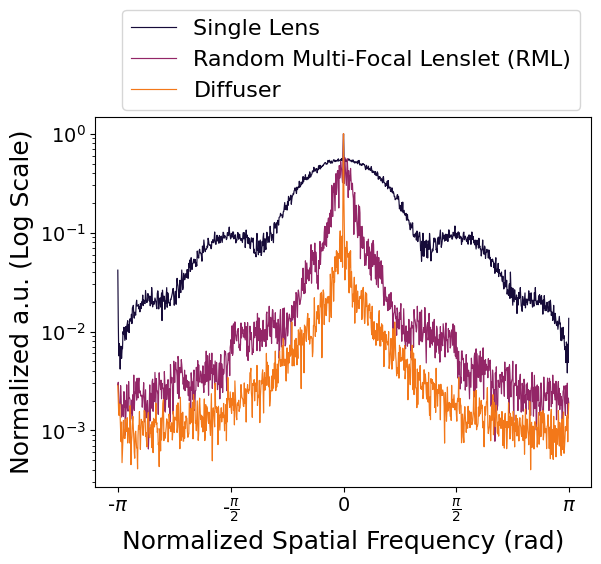

In [ ]:
gt_mtf = mtf_of_psf(gt_psf)
rml_mtf = mtf_of_psf(rml_psf)
diffuser_mtf = mtf_of_psf(diffuser_psf)

downscale_factor = 2
exponential_factor = 0.3

print(np.max(gt_mtf), np.max(rml_mtf), np.max(diffuser_mtf))
print(gt_mtf[600, 1920//2], rml_mtf[600, 1920//2], diffuser_mtf[600, 1920//2])
class ExpNorm(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, exponent=0.3):
        self.exponent = exponent
        super().__init__(vmin, vmax)

    def __call__(self, value, clip=False):
        return np.power(value, self.exponent)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

norm = ExpNorm(vmin=np.min([np.min(gt_mtf[gt_mtf > 0]),
                             np.min(rml_mtf[rml_mtf > 0]),
                             np.min(diffuser_mtf[diffuser_mtf > 0])]),
                vmax=1.0, exponent=exponential_factor)

im1 = axes[0].imshow(gt_mtf, cmap='gray', norm=norm)
axes[0].axis('off')
axes[0].set_title("Single Lens MTF", fontsize=18)

im2 = axes[1].imshow(rml_mtf, cmap='gray', norm=norm)
axes[1].axis('off')
axes[1].set_title("Random Multi-Focal Lenslet MTF", fontsize=18)

im3 = axes[2].imshow(diffuser_mtf, cmap='gray', norm=norm)
axes[2].axis('off')
axes[2].set_title("Diffuser MTF", fontsize=18)

cbar = fig.colorbar(im3, ax=axes, fraction=0.02, pad=0.02, spacing='uniform')
cbar.set_label('Normalized a.u.', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.savefig(save_dir + '2D_mtfs.pdf', bbox_inches='tight', transparent=True)

horizontal_indices = np.arange(gt_mtf.shape[1])
halfway_point = gt_mtf.shape[1] // 2

cross_section_idx = gt_mtf.shape[0] // 2

print(diffuser_mtf[cross_section_idx, halfway_point])
plt.figure()
plt.plot((horizontal_indices - halfway_point) / halfway_point * np.pi, gt_mtf[cross_section_idx, :], color=colors[0], label='Single Lens')
plt.plot((horizontal_indices - halfway_point) / halfway_point * np.pi, rml_mtf[cross_section_idx, :], color=colors[3], label='Random Multi-Focal Lenslet (RML)')
plt.plot((horizontal_indices - halfway_point) / halfway_point * np.pi, diffuser_mtf[cross_section_idx, :], color=colors[6], label='Diffuser')
plt.yscale('log')
plt.legend(loc='upper right', fontsize=legend_fontsize, bbox_to_anchor=(1, 1.32))
plt.xticks(np.arange(-np.pi, np.pi + 0.1, np.pi / 2), [r'-$\pi$', r'-$\frac{\pi}{2}$', 0, r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Normalized a.u. (Log Scale)", fontsize=18)
plt.xlabel("Normalized Spatial Frequency (rad)", fontsize=18)
plt.savefig(save_dir + '1D_mtf_cross_section.pdf', bbox_inches='tight', transparent=True)

# now include binning for the cross-sections of the MTFs - use max block reduce with 2x factor
gt_mtf = skimage.measure.block_reduce(gt_mtf, block_size=(downscale_factor, downscale_factor), func=np.max)
rml_mtf = skimage.measure.block_reduce(rml_mtf, block_size=(downscale_factor, downscale_factor), func=np.max)
diffuser_mtf = skimage.measure.block_reduce(diffuser_mtf, block_size=(downscale_factor, downscale_factor), func=np.max)
print(np.max(gt_mtf), np.max(rml_mtf), np.max(diffuser_mtf))
horizontal_indices = np.arange(gt_mtf.shape[1])
halfway_point = gt_mtf.shape[1] // 2

cross_section_idx = gt_mtf.shape[0] // 2

print(diffuser_mtf[cross_section_idx, halfway_point])
plt.figure()
plt.plot((horizontal_indices - halfway_point) / halfway_point * np.pi, gt_mtf[cross_section_idx, :], color=colors[0], label='Single Lens', linewidth=0.85)
plt.plot((horizontal_indices - halfway_point) / halfway_point * np.pi, rml_mtf[cross_section_idx, :], color=colors[3], label='Random Multi-Focal Lenslet (RML)', linewidth=0.85)
plt.plot((horizontal_indices - halfway_point) / halfway_point * np.pi, diffuser_mtf[cross_section_idx, :], color=colors[6], label='Diffuser', linewidth=0.85)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=legend_fontsize, bbox_to_anchor=(1, 1.32))
plt.xticks(np.arange(-np.pi, np.pi + 0.1, np.pi / 2), [r'-$\pi$', r'-$\frac{\pi}{2}$', 0, r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Normalized a.u. (Log Scale)", fontsize=18)
plt.xlabel("Normalized Spatial Frequency (rad)", fontsize=18)
plt.savefig(save_dir + '1D_mtf_cross_section.pdf', bbox_inches='tight', transparent=True)

## Plot the PSF images: Fig. 4a

In [ ]:
import matplotlib.colors as mcolors

lime = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ['black', 'lime'])

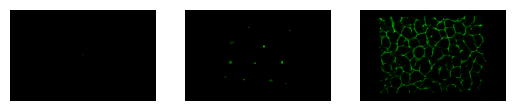

In [59]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(gt_psf / np.max(gt_psf), cmap=lime, vmax=0.3)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(rml_psf / np.max(rml_psf), cmap=lime, vmax=0.3)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(diffuser_psf / np.max(diffuser_psf), cmap=lime, vmax=0.3)
plt.axis('off')
plt.savefig(save_dir + 'experimental_psfs.pdf', bbox_inches='tight', transparent=True)

### Visualize Selected Measurements and Resulting Processed Versions: Fig. 4a

In [ ]:
measurement_dir = '/home/lakabuli/cosmos_drive/0-25k/'
rml_dir = measurement_dir + 'rml/'
diffuser_dir = measurement_dir + 'diffusercam/'
gt_dir = measurement_dir + 'ground_truth/'
undistorted_gt_dir = '/home/lakabuli/cosmos_drive/undistorted_images/'

gt_to_rml_dir = '/home/lakabuli/cosmos_drive/undistorted_GT2RML/'

In [ ]:
processed_gt_path = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/gt_dataset_100_patch_11000_images.npy'
processed_rml_path = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/rml_dataset_100_patch_11000_images.npy'
processed_diffuser_path = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/diffuser_dataset_100_patch_11000_images.npy'
gt_dataset = np.load(processed_gt_path)
gt_dataset = gt_dataset / np.mean(gt_dataset) * 500
rml_dataset = np.load(processed_rml_path)
rml_dataset = rml_dataset / np.mean(rml_dataset) * 500
diffuser_dataset = np.load(processed_diffuser_path)
diffuser_dataset = diffuser_dataset / np.mean(diffuser_dataset) * 500

In [ ]:
object_indices = [64, 89, 2, 1]

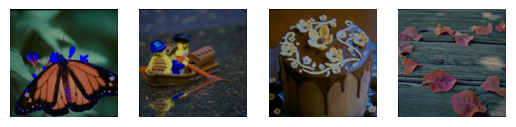

In [ ]:
plt.figure()
for idx, object_index in enumerate(object_indices):
    gt_images = undistorted_gt_dir + 'undistorted_img_{}_cam_2.tiff'.format(object_index)
    gt_images = plt.imread(gt_images)
    gt_images = gt_images[196:1021, 505:1330]
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(gt_images)
    plt.axis('off')
plt.savefig(save_dir + 'undistorted_gt_images.pdf', bbox_inches='tight', transparent=True)

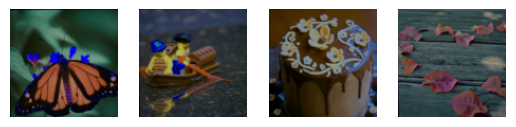

In [ ]:
plt.figure()
for idx, object_index in enumerate(object_indices):
    gt_images = undistorted_gt_dir + 'undistorted_img_{}_cam_2.tiff'.format(object_index)
    gt_images = plt.imread(gt_images)
    gt_images = resize(gt_images, (150, 240), anti_aliasing=True).astype(np.float32)
    gt_images = gt_images[25:127, 63:165]
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(gt_images)
    plt.axis('off')
plt.savefig(save_dir + 'downsampled_undistorted_gt_images.pdf', bbox_inches='tight', transparent=True)

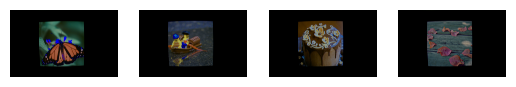

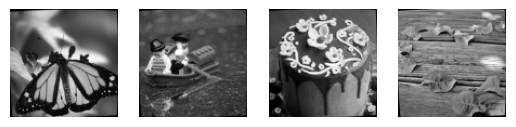

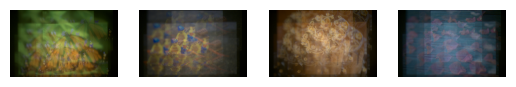

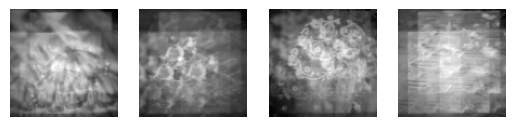

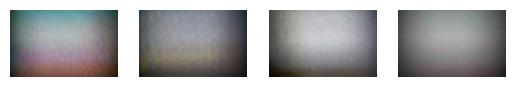

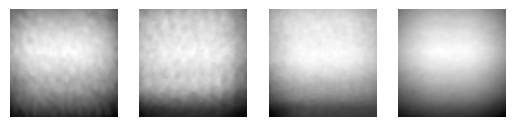

In [ ]:
plt.figure()
for idx, object_index in enumerate(object_indices):
    gt_image = gt_dir + 'img_{}_cam_2.tiff'.format(object_index)
    gt_image = plt.imread(gt_image)
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(np.fliplr(gt_image))
    plt.axis('off')
plt.savefig(save_dir + 'gt_captures.pdf', bbox_inches='tight', transparent=True)
plt.figure()
for idx, object_index in enumerate(object_indices):
    processed_gt_image = gt_dataset[object_index]
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(np.fliplr(processed_gt_image), cmap='gray')
    plt.axis('off')
plt.savefig(save_dir + 'gt_processed.pdf', bbox_inches='tight', transparent=True)
plt.figure()
for idx, object_index in enumerate(object_indices):
    rml_image = rml_dir + 'img_{}_cam_1.tiff'.format(object_index)
    rml_image = plt.imread(rml_image)
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(rml_image)
    plt.axis('off')
plt.savefig(save_dir + 'rml_captures.pdf', bbox_inches='tight', transparent=True)
plt.figure()
for idx, object_index in enumerate(object_indices):
    processed_rml_image = rml_dataset[object_index]
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(processed_rml_image, cmap='gray')
    plt.axis('off')
plt.savefig(save_dir + 'rml_processed.pdf', bbox_inches='tight', transparent=True)

plt.figure()
for idx, object_index in enumerate(object_indices):
    diffuser_image = diffuser_dir + 'img_{}_cam_0.tiff'.format(object_index)
    diffuser_image = plt.imread(diffuser_image)
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(diffuser_image)
    plt.axis('off')
plt.savefig(save_dir + 'diffuser_captures.pdf', bbox_inches='tight', transparent=True)
plt.figure()
for idx, object_index in enumerate(object_indices):
    processed_diffuser_image = diffuser_dataset[object_index]
    plt.subplot(1, len(object_indices), idx + 1)
    plt.imshow(processed_diffuser_image, cmap='gray')
    plt.axis('off')
plt.savefig(save_dir + 'diffuser_processed.pdf', bbox_inches='tight', transparent=True)

### Visualize Reconstructions and Ground Truths, Include Homography: Fig. 4d

In [ ]:
dc_homog_path = '/home/lakabuli/cosmos_drive/DC_homographies/'

dc_homography = torch.load(dc_homog_path + 'DC2GT_homography_x8_color_detached.npy')
print(dc_homography)

tensor([[[ 7.9988e-01,  1.3962e-02,  1.4967e+01],
         [-1.3962e-02,  7.9988e-01,  2.5185e+01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])


(5, 3, 150, 240)
torch.Size([5, 3, 150, 240])


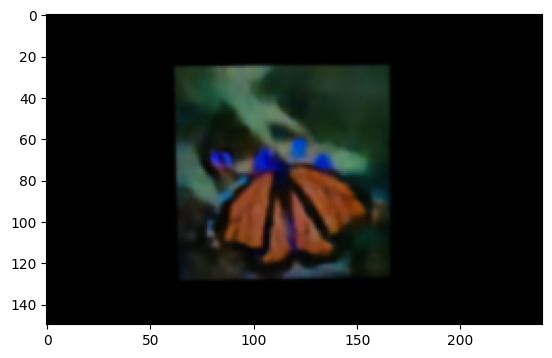

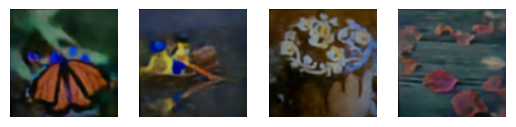

In [ ]:
diffusercam_recons = np.load('/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/uncropped_inference_images_diffuser.npy')
print(diffusercam_recons.shape)
diffusercam_recons_tensor = torch.from_numpy(diffusercam_recons)
diffusercam_recons_tensor = warp_perspective(diffusercam_recons_tensor, dc_homography, dsize=(150, 240), align_corners=True)
print(diffusercam_recons_tensor.shape)
diffusercam_recons_warped = np.moveaxis(diffusercam_recons_tensor.numpy(), 1, -1)
plt.imshow(diffusercam_recons_warped[0, :, :])

object_indices_from_recon = [0, 2, 4, 3]
plt.figure()
for idx, object_index in enumerate(object_indices_from_recon):
    plt.subplot(1, len(object_indices_from_recon), idx + 1)
    cropped_image = diffusercam_recons_warped[object_index][25:127, 63:165]
    plt.imshow(cropped_image)
    plt.axis('off')
plt.savefig(save_dir + 'diffusercam_recons_warped_to_gt.pdf', bbox_inches='tight', transparent=True)

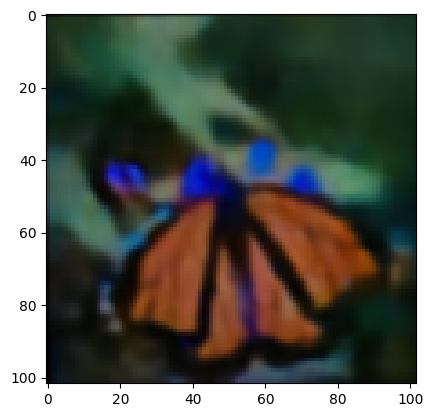

In [153]:
plt.imshow(diffusercam_recons_warped[0][25:127, 63:165])

### Repeat for RML

In [13]:
rml_homog_path = '/home/lakabuli/cosmos_drive/RML_homographies/' 

rml_homography = torch.load(rml_homog_path + 'RML2GT_homography_x8_color_detached.npy')
print(rml_homography)

tensor([[[ 9.1347e-01,  2.0777e-04,  3.5082e+00],
         [-2.1037e-04,  9.0218e-01,  1.0136e+01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])


(5, 3, 150, 240)
torch.Size([5, 3, 150, 240])


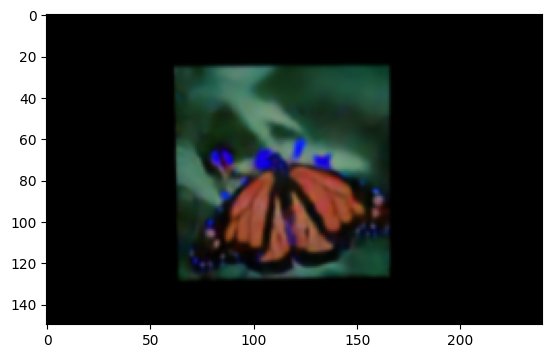

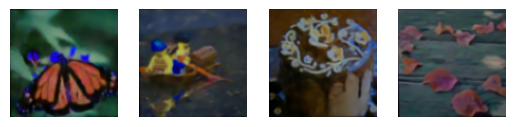

In [ ]:
rml_recons = np.load('/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/uncropped_inference_images_rml.npy')
print(rml_recons.shape)

rml_recons_tensor = torch.from_numpy(rml_recons)
rml_recons_tensor = warp_perspective(rml_recons_tensor, rml_homography, dsize=(150, 240), align_corners=True)
print(rml_recons_tensor.shape)
rml_recons_warped = np.moveaxis(rml_recons_tensor.numpy(), 1, -1)
plt.imshow(rml_recons_warped[0, :, :])

object_indices_from_recon = [0, 2, 4, 3]
plt.figure()
for idx, object_index in enumerate(object_indices_from_recon):
    plt.subplot(1, len(object_indices_from_recon), idx + 1)
    cropped_image = rml_recons_warped[object_index][25:127, 63:165]
    plt.imshow(cropped_image)
    plt.axis('off')
plt.savefig(save_dir + 'rml_recons_warped_to_gt.pdf', bbox_inches='tight', transparent=True)

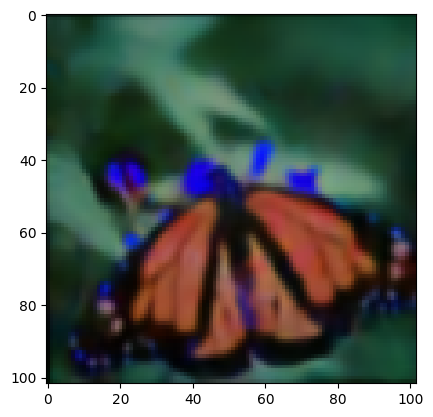

In [17]:
plt.imshow(rml_recons_warped[0][25:127, 63:165])

### Make MI Plots for Each of the Encoders: Fig. 4c

In [ ]:
mi_dir = '/home/lakabuli/workspace/LenslessInfoDesign/experimental_eval/data/'
seed_values = [42, 4, 31, 50, 77]

[0.9805515 0.9372596 1.020822 ]
[0.43454304 0.40983477 0.45867684]
[0.04495971 0.02916748 0.0584945 ]
[0.9667344 0.9359279 1.0025823]
[0.43101948 0.4061647  0.45745   ]
[0.04796046 0.03124902 0.06167615]
[0.98485655 0.93964636 1.0193962 ]
[0.44579965 0.41776663 0.47634465]
[0.05516515 0.04192632 0.06782329]
[0.9453762  0.9026867  0.98069626]
[0.4384457  0.4157717  0.45860013]
[0.04348065 0.03100032 0.05759226]
[0.96248573 0.92603403 0.99596536]
[0.44162804 0.41805384 0.46832126]
[0.03852274 0.0238687  0.05021628]
[np.float32(0.9805515), np.float32(0.9667344), np.float32(0.98485655), np.float32(0.9453762), np.float32(0.96248573)] 3
[np.float32(0.43454304), np.float32(0.43101948), np.float32(0.44579965), np.float32(0.4384457), np.float32(0.44162804)] 1
[np.float32(0.044959705), np.float32(0.047960456), np.float32(0.055165153), np.float32(0.043480653), np.float32(0.03852274)] 4


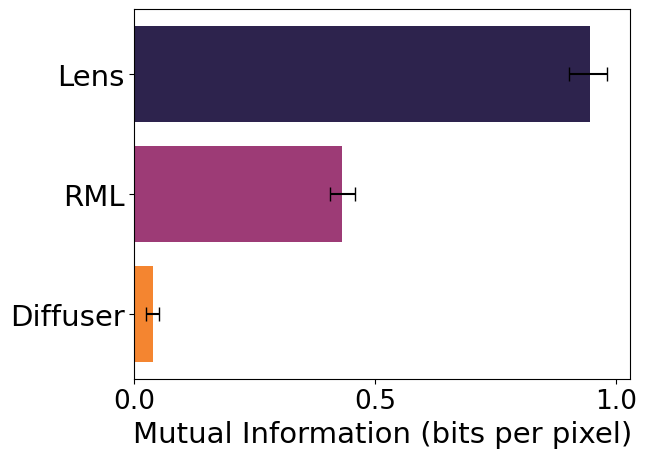

In [ ]:
diffuser_mis = []
diffuser_lowers = []
diffuser_uppers = []
rml_mis = []
rml_lowers = []
rml_uppers = []
gt_mis = []
gt_lowers = []
gt_uppers = []

for seed_value in seed_values:
    gt_mi = np.load(mi_dir + 'pixelcnn_gt_patchsize_100_seed_{}_mi_estimate.npy'.format(seed_value))
    print(gt_mi)
    rml_mi = np.load(mi_dir + 'pixelcnn_rml_patchsize_100_seed_{}_mi_estimate.npy'.format(seed_value))
    print(rml_mi)
    diffuser_mi = np.load(mi_dir + 'pixelcnn_diffuser_patchsize_100_seed_{}_mi_estimate.npy'.format(seed_value))
    print(diffuser_mi)
    gt_mis.append(gt_mi[0])
    gt_lowers.append(gt_mi[1])
    gt_uppers.append(gt_mi[2])
    rml_mis.append(rml_mi[0])
    rml_lowers.append(rml_mi[1])
    rml_uppers.append(rml_mi[2])
    diffuser_mis.append(diffuser_mi[0])
    diffuser_lowers.append(diffuser_mi[1])
    diffuser_uppers.append(diffuser_mi[2])
print(gt_mis, np.argmin(gt_mis))
print(rml_mis, np.argmin(rml_mis))
print(diffuser_mis, np.argmin(diffuser_mis))

best_gt_mi = np.min(gt_mis)
best_gt_mi_idx = np.argmin(gt_mis)
best_gt_mi_lower = gt_lowers[best_gt_mi_idx]
best_gt_mi_upper = gt_uppers[best_gt_mi_idx]

best_rml_mi = np.min(rml_mis)
best_rml_mi_idx = np.argmin(rml_mis)
best_rml_mi_lower = rml_lowers[best_rml_mi_idx]
best_rml_mi_upper = rml_uppers[best_rml_mi_idx]
best_diffuser_mi = np.min(diffuser_mis)
best_diffuser_mi_idx = np.argmin(diffuser_mis)
best_diffuser_mi_lower = diffuser_lowers[best_diffuser_mi_idx]
best_diffuser_mi_upper = diffuser_uppers[best_diffuser_mi_idx]

values = [best_diffuser_mi, best_rml_mi, best_gt_mi]
labels = ["Diffuser", "RML", "Lens"]
colors_bar = [colors[6], colors[3], colors[0]]
lower_errors = [best_diffuser_mi - best_diffuser_mi_lower, best_rml_mi - best_rml_mi_lower, best_gt_mi - best_gt_mi_lower]
upper_errors = [best_diffuser_mi_upper - best_diffuser_mi, best_rml_mi_upper - best_rml_mi, best_gt_mi_upper - best_gt_mi]

errors = [lower_errors, upper_errors]
plt.figure()
plt.barh([0, 1, 2], values, xerr=errors, capsize=5, color=colors_bar, alpha=0.9)

plt.yticks([0, 1, 2], labels, fontsize=axis_label_fontsize, rotation=0)
plt.xlabel("Mutual Information (bits per pixel)", fontsize=axis_label_fontsize)
plt.xticks([0, 0.5, 1.0], fontsize=tick_fontsize)

plt.savefig(save_dir + 'experimental_mi_values.pdf', bbox_inches='tight', transparent=True)